In [1]:
# 04_clustering_evaluation_and_visualization
print("Tune K, evaluate clusters, choose final model and visualize clusters.")


Tune K, evaluate clusters, choose final model and visualize clusters.


In [33]:
# Cell 1
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

PROJECT_ROOT = Path("C:/Users/KIIT/OneDrive/Documents/Labmentix/netflix")
OUT_DIR = PROJECT_ROOT / "outputs"
X_path = OUT_DIR / "X_combined.npy"
CLEANED = OUT_DIR / "cleaned_netflix.csv"

if not X_path.exists():
    raise FileNotFoundError(f"Combined features not found: {X_path}. Please run Notebook 03 first.")

X_combined = np.load(X_path)
df = pd.read_csv(CLEANED)
print("Loaded X_combined shape:", X_combined.shape)


Loaded X_combined shape: (7787, 84)


K=2 -> silhouette=0.2697, db=1.4268
K=3 -> silhouette=0.2967, db=1.2412
K=4 -> silhouette=0.1887, db=1.7542
K=5 -> silhouette=0.1855, db=1.7051
K=6 -> silhouette=0.1577, db=1.9481
K=7 -> silhouette=0.1645, db=1.9240
K=8 -> silhouette=0.1592, db=1.9544
K=9 -> silhouette=0.1637, db=1.9879
K=10 -> silhouette=0.1615, db=1.9456


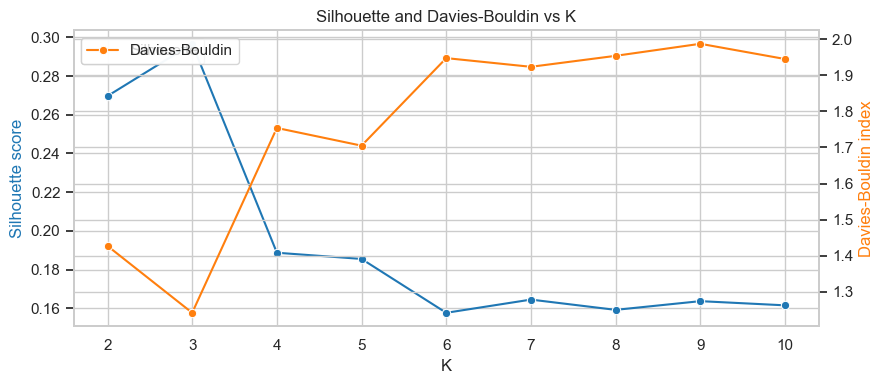

In [34]:
# Cell 2
ks = list(range(2, 11))
sil_scores = []
db_scores = []
for k in ks:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_combined)
    sil = silhouette_score(X_combined, labels)
    db = davies_bouldin_score(X_combined, labels)
    sil_scores.append(sil)
    db_scores.append(db)
    print(f"K={k} -> silhouette={sil:.4f}, db={db:.4f}")

# Plot (silhouette left, DB right)
plt.figure(figsize=(9,4))
ax = plt.gca()
ax2 = ax.twinx()
sns.lineplot(x=ks, y=sil_scores, marker="o", label="Silhouette", ax=ax, color="tab:blue")
sns.lineplot(x=ks, y=db_scores, marker="o", label="Davies-Bouldin", ax=ax2, color="tab:orange")
ax.set_xlabel("K")
ax.set_ylabel("Silhouette score", color="tab:blue")
ax2.set_ylabel("Davies-Bouldin index", color="tab:orange")
ax.set_xticks(ks)
plt.title("Silhouette and Davies-Bouldin vs K")
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()


In [35]:
#Cell 3-Suggest K by maximum silhouette (tie-break by lowest DB among ties)
best_k = ks[np.argmax(sil_scores)]
best_sil = max(sil_scores)
print(f"Suggested K by silhouette: {best_k} (silhouette={best_sil:.4f})")

# optionally refine by checking DB among top silhouette Ks
top_idxs = [i for i, s in enumerate(sil_scores) if s >= (0.98*best_sil)]
candidate_k = sorted([(ks[i], db_scores[i]) for i in top_idxs], key=lambda x: x[1])
final_k = candidate_k[0][0] if candidate_k else best_k
print(f"Final chosen K (balanced with DB): {final_k}")


Suggested K by silhouette: 3 (silhouette=0.2967)
Final chosen K (balanced with DB): 3


In [36]:
# Cell 4
chosen_k = int(final_k)
km_final = KMeans(n_clusters=chosen_k, random_state=42)
labels = km_final.fit_predict(X_combined)
df["cluster"] = labels
# Save df with clusters
df.to_csv(OUT_DIR / "netflix_with_clusters.csv", index=False)
print(f"Fitted final KMeans with K={chosen_k} and saved netflix_with_clusters.csv")


Fitted final KMeans with K=3 and saved netflix_with_clusters.csv


Available columns in df: ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description', 'duration_num', 'genres_list', 'cluster']

cluster_df preview:


,Cluster,Count
0,0,4682
1,1,2639
2,2,466


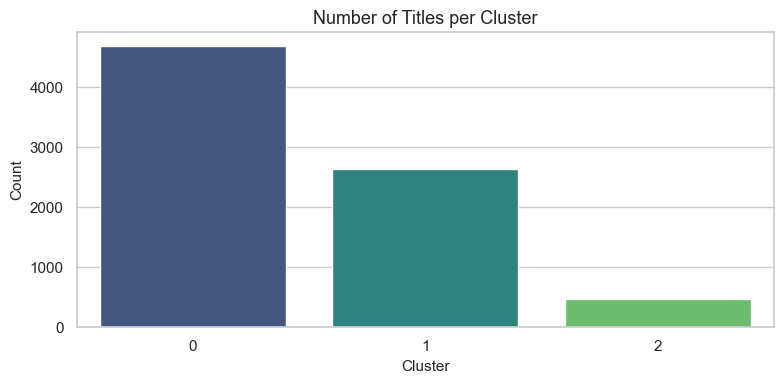

✅ Cluster distribution plotted (no warnings).


In [37]:
# Cell 5 (robust replacement; no error, no warnings)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Defensive: show cluster column presence and a small sample
print("Available columns in df:", df.columns.tolist()[:50])
if 'cluster' not in df.columns:
    raise KeyError("DataFrame does not contain 'cluster' column. Run the clustering step first.")

# Create a clean DataFrame for plotting
cluster_counts = df['cluster'].value_counts().sort_index()
cluster_df = pd.DataFrame({
    "Cluster": cluster_counts.index.astype(str),   # make categorical labels strings
    "Count":  cluster_counts.values
})

print("\ncluster_df preview:")
display(cluster_df.head(20))

# Plot (use hue so Seaborn accepts palette without deprecation warning)
plt.figure(figsize=(8,4))
ax = sns.barplot(data=cluster_df, x="Cluster", y="Count", hue="Cluster", palette="viridis", dodge=False)

# Remove redundant legend (we don't need it because colors match x labels)
leg = ax.get_legend()
if leg is not None:
    leg.remove()

ax.set_title("Number of Titles per Cluster", fontsize=13)
ax.set_xlabel("Cluster", fontsize=11)
ax.set_ylabel("Count", fontsize=11)
plt.tight_layout()
plt.show()

print("✅ Cluster distribution plotted (no warnings).")


In [38]:
# Cell 6 (robust, error-free replacement)
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# === Paths (explicit) ===
PROJECT_ROOT = Path("C:/Users/KIIT/OneDrive/Documents/Labmentix/netflix")
OUT_DIR = PROJECT_ROOT / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)
CLUSTER_CSV = OUT_DIR / "netflix_with_clusters.csv"
CLEANED_CSV = OUT_DIR / "cleaned_netflix.csv"

# === 1) Load dataframe (use in-memory if present) ===
try:
    df  # use existing in-memory df if available
    print("Using existing dataframe 'df' from memory.")
except NameError:
    # try to load clustered csv, else fallback to cleaned csv
    if CLUSTER_CSV.exists():
        df = pd.read_csv(CLUSTER_CSV)
        print(f"Loaded '{CLUSTER_CSV.name}' into df.")
    elif CLEANED_CSV.exists():
        df = pd.read_csv(CLEANED_CSV)
        print(f"Cluster CSV not found. Loaded cleaned CSV '{CLEANED_CSV.name}' into df as fallback.")
    else:
        raise FileNotFoundError(f"Neither {CLUSTER_CSV} nor {CLEANED_CSV} found. Run previous notebooks or put files in outputs/.")

# === 2) Ensure cluster column exists ===
if 'cluster' not in df.columns:
    raise KeyError("'cluster' column not found in df. Run Notebook 04 to produce cluster labels (netflix_with_clusters.csv).")

# === 3) Build cluster_list ===
cluster_list = sorted(df['cluster'].dropna().unique().tolist())
print("Clusters detected:", cluster_list)

# === 4) Robust genres_list normalizer ===
def ensure_list_safe(x):
    """
    Normalize various representations into a python list of strings.
    Accepts: list, tuple, numpy array, string that is comma-separated,
    or stringified list like "['Drama', 'Comedy']".
    """
    # None or NaN-like
    if x is None:
        return []
    # numpy scalar NaN
    if isinstance(x, (float,)) and np.isnan(x):
        return []
    # If already a list / tuple / ndarray -> convert elements to strings
    if isinstance(x, (list, tuple, np.ndarray)):
        out = []
        for item in x:
            if item is None:
                continue
            s = str(item).strip()
            if s == "" or s.lower() == "nan":
                continue
            out.append(s.strip("'\" "))
        return out
    # Now x is likely a scalar (string or other). Convert to string and parse.
    s = str(x).strip()
    if s == "" or s.lower() == "nan":
        return []
    # handle stringified list: "['A', 'B']" or '["A","B"]'
    if s.startswith("[") and s.endswith("]"):
        inner = s[1:-1].strip()
        if inner == "":
            return []
        parts = [p.strip().strip("'\" ") for p in inner.split(",") if p.strip()]
        return parts
    # otherwise treat as comma-separated
    parts = [p.strip() for p in s.split(",") if p.strip()]
    return parts

# Apply normalization depending on what's present
if 'genres_list' in df.columns:
    # apply ensure_list_safe elementwise
    df['genres_list'] = df['genres_list'].apply(ensure_list_safe)
    print("Normalized existing 'genres_list' column.")
elif 'listed_in' in df.columns:
    df['genres_list'] = df['listed_in'].fillna("").astype(str).apply(lambda s: [t.strip() for t in s.split(",") if t.strip()])
    print("Converted 'listed_in' -> 'genres_list'.")
else:
    df['genres_list'] = [[] for _ in range(len(df))]
    print("No genre columns found; created empty 'genres_list' entries.")

# Quick sanity check
print("Sample genres_list values (first 6 rows):")
display(df['genres_list'].head(6))

# === 5) Recompute df_genres_summary (top 8 per cluster) ===
rows = []
for c in cluster_list:
    exploded = df[df['cluster'] == c]['genres_list'].explode().dropna()
    top = exploded.value_counts().head(8)
    topstr = "; ".join([f"{g} ({int(v)})" for g, v in top.items()])
    rows.append({"cluster": int(c), "n_titles": int((df['cluster'] == c).sum()), "top_genres": topstr})
df_genres_summary = pd.DataFrame(rows).sort_values("cluster")
print("Recomputed df_genres_summary:")
display(df_genres_summary)

# === 6) Compute lightweight TF-IDF cluster keywords (safe) ===
cluster_top_terms = {}
compute_tfidf = True  # set to False to skip keyword extraction
if compute_tfidf:
    if 'description' not in df.columns:
        print("No 'description' column; skipping TF-IDF keyword extraction.")
        for c in cluster_list:
            cluster_top_terms[c] = []
    else:
        try:
            print("Computing TF-IDF (max_features=1000) for cluster keywords — this is memory-conscious.")
            corpus = df['description'].fillna("").astype(str).tolist()
            tfidf = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1,2))
            X_tfidf = tfidf.fit_transform(corpus)
            feature_names = np.array(tfidf.get_feature_names_out())
            for c in cluster_list:
                idx = np.where(df['cluster'] == c)[0]
                if len(idx) == 0:
                    cluster_top_terms[c] = []
                    continue
                avg = X_tfidf[idx].mean(axis=0)
                avg = np.asarray(avg).ravel()
                nonzero = np.where(avg > 0)[0]
                if nonzero.size == 0:
                    cluster_top_terms[c] = []
                    continue
                topn = min(12, nonzero.size)
                top_indices = np.argsort(avg)[-topn:][::-1]
                cluster_top_terms[c] = feature_names[top_indices].tolist()
            print("TF-IDF keywords computed successfully.")
        except Exception as e:
            print("Warning: TF-IDF step failed or ran out of memory. Error:", e)
            for c in cluster_list:
                cluster_top_terms[c] = []
else:
    for c in cluster_list:
        cluster_top_terms[c] = []

# === 7) Build summary_df with top genres, keywords, sample titles ===
summary_rows = []
for c in cluster_list:
    sub = df[df['cluster'] == c]
    samples = sub['title'].dropna().astype(str).head(8).tolist()
    sample_str = " | ".join(samples)
    top_genres = df_genres_summary[df_genres_summary['cluster'] == c]['top_genres'].values
    top_genres = top_genres[0] if len(top_genres) > 0 else ""
    top_terms = ", ".join(cluster_top_terms.get(c, [])[:6])
    summary_rows.append({
        "cluster": int(c),
        "n_titles": int((df['cluster'] == c).sum()),
        "top_genres": top_genres,
        "top_terms": top_terms,
        "sample_titles": sample_str
    })

summary_df = pd.DataFrame(summary_rows).sort_values("cluster")
print("Constructed summary_df:")
display(summary_df)

# === 8) Save summary table and interpretation snippets ===
summary_csv_path = OUT_DIR / "cluster_summary_table.csv"
summary_df.to_csv(summary_csv_path, index=False)
print("Saved cluster_summary_table.csv to:", summary_csv_path)

interp_lines = []
for _, row in summary_df.iterrows():
    c = int(row['cluster'])
    genres = row['top_genres'] or "N/A"
    terms = row['top_terms'] or "N/A"
    samples = row['sample_titles'] or "N/A"
    interp_lines.append(
        f"**Cluster {c}**  \n"
        f"- Top genres: {genres}  \n"
        f"- Keywords: {terms}  \n"
        f"- Example titles: {samples}  \n"
        f"- Short rationale: __(edit to describe what unites these titles)__  \n"
    )

interp_path = OUT_DIR / "cluster_interpretation_snippets.md"
with open(interp_path, "w", encoding="utf-8") as f:
    f.write("# Cluster interpretation snippets (auto-generated)\n\n")
    f.write("\n".join(interp_lines))
print("Wrote cluster_interpretation_snippets.md to:", interp_path)

# === Done ===
print("\nPreview (first 5 rows of summary_df):")
display(summary_df.head())


Using existing dataframe 'df' from memory.
Clusters detected: [0, 1, 2]
Normalized existing 'genres_list' column.
Sample genres_list values (first 6 rows):


0    [International TV Shows, TV Dramas, TV Sci-Fi ...
1                       [Dramas, International Movies]
2                [Horror Movies, International Movies]
3    [Action & Adventure, Independent Movies, Sci-F...
4                                             [Dramas]
5    [International TV Shows, TV Dramas, TV Mysteries]
Name: genres_list, dtype: object

Recomputed df_genres_summary:


,cluster,n_titles,top_genres
0,0,4682,International Movies (2253); Dramas (1886); Co...
1,1,2639,International TV Shows (1197); TV Dramas (700)...
2,2,466,Dramas (208); International Movies (166); Come...


Computing TF-IDF (max_features=1000) for cluster keywords — this is memory-conscious.
TF-IDF keywords computed successfully.
Constructed summary_df:


,cluster,n_titles,top_genres,top_terms,sample_titles
0,0,4682,International Movies (2253); Dramas (1886); Co...,"life, young, man, new, family, woman",7:19 | 23:59 | 9 | 21 | 122 | 706 | 1920 | 1922
1,1,2639,International TV Shows (1197); TV Dramas (700)...,"series, world, life, friends, new, family",3% | 46 | 1983 | 1994 | Feb-09 | ​SAINT SEIYA:...
2,2,466,Dramas (208); International Movies (166); Come...,"young, family, man, love, woman, life",187 | 28 Days | 300 Miles to Heaven | A Bridge...


Saved cluster_summary_table.csv to: C:\Users\KIIT\OneDrive\Documents\Labmentix\netflix\outputs\cluster_summary_table.csv
Wrote cluster_interpretation_snippets.md to: C:\Users\KIIT\OneDrive\Documents\Labmentix\netflix\outputs\cluster_interpretation_snippets.md

Preview (first 5 rows of summary_df):


,cluster,n_titles,top_genres,top_terms,sample_titles
0,0,4682,International Movies (2253); Dramas (1886); Co...,"life, young, man, new, family, woman",7:19 | 23:59 | 9 | 21 | 122 | 706 | 1920 | 1922
1,1,2639,International TV Shows (1197); TV Dramas (700)...,"series, world, life, friends, new, family",3% | 46 | 1983 | 1994 | Feb-09 | ​SAINT SEIYA:...
2,2,466,Dramas (208); International Movies (166); Come...,"young, family, man, love, woman, life",187 | 28 Days | 300 Miles to Heaven | A Bridge...


In [39]:
# Cell 7 (corrected, robust, no ambiguous boolean checks)
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import pandas as pd
import numpy as np
from pandas.api.types import is_list_like
from sklearn.feature_extraction.text import TfidfVectorizer

# Paths
PROJECT_ROOT = Path("C:/Users/KIIT/OneDrive/Documents/Labmentix/netflix")
OUT_DIR = PROJECT_ROOT / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)
CLUSTER_CSV = OUT_DIR / "netflix_with_clusters.csv"
SUMMARY_CSV = OUT_DIR / "cluster_summary_table.csv"

# Load df
try:
    df  # use in-memory if present
    print("Using in-memory df.")
except NameError:
    if CLUSTER_CSV.exists():
        df = pd.read_csv(CLUSTER_CSV)
        print(f"Loaded dataframe from {CLUSTER_CSV}")
    else:
        raise FileNotFoundError(f"{CLUSTER_CSV} not found. Run Notebook 4 to produce it.")

# Helper: robust normalizer for genres_list
def ensure_list_safe(x):
    """
    Normalize many possible representations to a list of genre strings.
    Handles: list/tuple/ndarray, pandas NA, empty strings, comma-separated strings,
    and stringified lists like "['Drama','Comedy']".
    """
    # None or obvious NA
    if x is None:
        return []
    # If it's list-like (but not a string), iterate
    if is_list_like(x) and not isinstance(x, (str, bytes)):
        out = []
        for it in x:
            if pd.isna(it):
                continue
            s = str(it).strip()
            if s == "" or s.lower() == "nan":
                continue
            out.append(s.strip("'\" "))
        return out
    # Scalar case
    if pd.isna(x):
        return []
    s = str(x).strip()
    if s == "" or s.lower() == "nan":
        return []
    # stringified list: "['A', 'B']"
    if s.startswith("[") and s.endswith("]"):
        inner = s[1:-1].strip()
        if inner == "":
            return []
        parts = [p.strip().strip("'\" ") for p in inner.split(",") if p.strip()]
        return parts
    # otherwise comma-separated
    return [p.strip() for p in s.split(",") if p.strip()]

# Normalize or create genres_list
if 'genres_list' in df.columns:
    # apply in a vectorized-safe manner
    df['genres_list'] = df['genres_list'].apply(ensure_list_safe)
    print("Normalized existing 'genres_list'.")
elif 'listed_in' in df.columns:
    df['genres_list'] = df['listed_in'].fillna("").astype(str).apply(lambda s: [t.strip() for t in s.split(",") if t.strip()])
    print("Converted 'listed_in' -> 'genres_list'.")
else:
    df['genres_list'] = [[] for _ in range(len(df))]
    print("No genre columns found; created empty 'genres_list' entries.")

# Basic presence flags
has_description = 'description' in df.columns
has_title = 'title' in df.columns

# Build cluster list
cluster_list = sorted(df['cluster'].dropna().unique().tolist())
print("Clusters detected:", cluster_list)

# TF-IDF keywords per cluster (safe)
compute_tfidf = True  # set False if memory is low
cluster_terms = {}
if compute_tfidf and has_description:
    try:
        corpus = df['description'].fillna("").astype(str).tolist()
        tfidf = TfidfVectorizer(max_features=800, stop_words='english', ngram_range=(1,2))
        X_tfidf = tfidf.fit_transform(corpus)
        feature_names = np.array(tfidf.get_feature_names_out())
        for c in cluster_list:
            idx = np.where(df['cluster'] == c)[0]
            if len(idx) == 0:
                cluster_terms[c] = []
                continue
            avg = X_tfidf[idx].mean(axis=0)
            avg = np.asarray(avg).ravel()
            nonzero = np.where(avg > 0)[0]
            if nonzero.size == 0:
                cluster_terms[c] = []
                continue
            topn = min(10, nonzero.size)
            top_idx = np.argsort(avg)[-topn:][::-1]
            cluster_terms[c] = [(feature_names[i], float(avg[i])) for i in top_idx]
        print("TF-IDF keywords computed (max_features=800).")
    except Exception as e:
        print("Warning: TF-IDF failed or OOM. Skipping keywords. Error:", e)
        for c in cluster_list:
            cluster_terms[c] = []
else:
    for c in cluster_list:
        cluster_terms[c] = []

# Helper to suggest a label
def suggest_label_from_genres(genres):
    if not genres:
        return "Cluster"
    tokens = []
    for g in genres[:2]:
        token = g.split("&")[0].split()[0]
        tokens.append(token)
    return " ".join(tokens)

# Build enhanced snippets
snippets = []
rows_for_csv = []
for c in cluster_list:
    sub = df[df['cluster'] == c]
    n_titles = int(sub.shape[0])
    # top genres with counts
    top_genres_ser = sub['genres_list'].explode().value_counts().head(8)
    top_genres_list = [f"{g} ({int(v)})" for g, v in top_genres_ser.items()] if not top_genres_ser.empty else []
    top_genre_names = list(top_genres_ser.index.astype(str)[:3])
    # top terms
    tterms = cluster_terms.get(c, [])
    top_terms_str = ", ".join([f"{t} ({s:.3f})" for t, s in tterms[:8]]) if tterms else "N/A"
    # sample titles with tiny description snippet (if available)
    sample_list = []
    if has_title:
        sample_rows = sub[['title', 'release_year']].drop_duplicates(subset=['title']).head(6)
        for _, r in sample_rows.iterrows():
            title = str(r['title'])
            year = ""
            if 'release_year' in sub.columns and not pd.isna(r.get('release_year', None)):
                year = f" ({int(r['release_year'])})"
            desc_snip = ""
            if has_description:
                desc_val = sub.loc[sub['title'] == title, 'description'].dropna().astype(str).values
                if len(desc_val) > 0:
                    snippet = desc_val[0].strip()
                    if len(snippet) > 80:
                        snippet = snippet[:77].rsplit(" ", 1)[0] + "..."
                    desc_snip = f" — {snippet}"
            sample_list.append(f"{title}{year}{desc_snip}")
    sample_str = " | ".join(sample_list) if sample_list else "N/A"

    suggested_label = suggest_label_from_genres(top_genre_names) if top_genre_names else "Cluster"
    # auto rationale
    rationale_parts = []
    if top_genre_names:
        rationale_parts.append("dominant genres: " + ", ".join(top_genre_names[:3]))
    if tterms and tterms != []:
        kw = ", ".join([t for t, _ in tterms[:3]])
        rationale_parts.append("keywords include: " + kw)
    auto_rationale = "This cluster groups titles with " + "; ".join(rationale_parts) + "." if rationale_parts else "Interpretation needed."

    snippet_md = (
        f"### Cluster {c} — (n={n_titles})\n\n"
        f"- **Suggested label:** {suggested_label}\n"
        f"- **Top genres:** {', '.join(top_genres_list) if top_genres_list else 'N/A'}\n"
        f"- **Top keywords (term (avg tfidf))**: {top_terms_str}\n"
        f"- **Example titles (title (year) — short description snippet):** {sample_str}\n"
        f"- **Auto rationale (edit as needed):** {auto_rationale}\n\n"
    )
    snippets.append(snippet_md)

    rows_for_csv.append({
        "cluster": int(c),
        "n_titles": n_titles,
        "top_genres": ", ".join(top_genre_names) if top_genre_names else "",
        "top_terms": ", ".join([t for t, _ in tterms[:5]]) if tterms else "",
        "sample_titles": sample_str
    })

# Save markdown and enhanced csv
out_md = OUT_DIR / "cluster_interpretation_snippets.md"
out_md.write_text("# Cluster interpretation snippets (enhanced)\n\n" + "\n".join(snippets), encoding="utf-8")
print("Wrote enhanced markdown to:", out_md)

enhanced_csv = OUT_DIR / "cluster_summary_table_enhanced.csv"
pd.DataFrame(rows_for_csv).sort_values("cluster").to_csv(enhanced_csv, index=False)
print("Saved enhanced CSV to:", enhanced_csv)

# Print all snippets for quick review in the notebook
for s in snippets:
    print(s)
    print("---")


Using in-memory df.
Normalized existing 'genres_list'.
Clusters detected: [0, 1, 2]
TF-IDF keywords computed (max_features=800).
Wrote enhanced markdown to: C:\Users\KIIT\OneDrive\Documents\Labmentix\netflix\outputs\cluster_interpretation_snippets.md
Saved enhanced CSV to: C:\Users\KIIT\OneDrive\Documents\Labmentix\netflix\outputs\cluster_summary_table_enhanced.csv
### Cluster 0 — (n=4682)

- **Suggested label:** International Dramas
- **Top genres:** International Movies (2253), Dramas (1886), Comedies (1304), Documentaries (686), Independent Movies (639), Action & Adventure (603), Romantic Movies (494), Thrillers (469)
- **Top keywords (term (avg tfidf))**: life (0.024), young (0.023), man (0.021), new (0.019), family (0.018), woman (0.018), documentary (0.018), love (0.015)
- **Example titles (title (year) — short description snippet):** 7:19 (2016) — After a devastating earthquake hits Mexico City, trapped survivors from all... | 23:59 (2011) — When an army recruit is found dead, h

In [40]:
# Cell 8-Purpose: save plots (cluster counts, PCA) and final summarized CSV (explicit output path; memory-safe)
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import joblib
import os

sns.set(style="whitegrid")
OUT_DIR = Path("C:/Users/KIIT/OneDrive/Documents/Labmentix/netflix/outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Load cluster_summary_table if available
summary_path = OUT_DIR / "cluster_summary_table.csv"
if not summary_path.exists():
    raise FileNotFoundError(f"{summary_path} not found. Run summary-building cell first.")
summary_df = pd.read_csv(summary_path)

# 1) Save cluster counts plot (construct DataFrame safely)
cluster_counts = summary_df[["cluster", "n_titles"]].copy()
cluster_counts = cluster_counts.rename(columns={"cluster": "Cluster", "n_titles": "Count"})
cluster_counts["Cluster"] = cluster_counts["Cluster"].astype(str)

plt.figure(figsize=(8,4))
ax = sns.barplot(data=cluster_counts, x="Cluster", y="Count", hue="Cluster", palette="viridis", dodge=False)
# remove legend to keep plot clean
if ax.get_legend() is not None:
    ax.get_legend().remove()
ax.set_title("Number of Titles per Cluster")
ax.set_xlabel("Cluster")
ax.set_ylabel("Count")
plt.tight_layout()
count_plot_path = OUT_DIR / "cluster_counts.png"
plt.savefig(count_plot_path, dpi=150, bbox_inches="tight")
plt.close()
print("Saved cluster counts plot to:", count_plot_path)

# 2) PCA visualization — prefer X_combined.npy if present (less re-compute); sample for memory safety
X_path = OUT_DIR / "X_combined.npy"
pca_saved = False
pca_plot_path = OUT_DIR / "pca_clusters_sample.png"
try:
    if X_path.exists():
        X = np.load(X_path, mmap_mode="r")  # memory-map if large
        n_samples = X.shape[0]
        sample_size = min(5000, n_samples)
        rng = np.random.default_rng(42)
        sample_idx = rng.choice(n_samples, size=sample_size, replace=False)
        X_sample = X[sample_idx]
        pca = PCA(n_components=2, random_state=42)
        coords = pca.fit_transform(X_sample)
        # create a small DataFrame to map back to cluster labels (use sample indices)
        # load clustered CSV for labels
        df_clusters = pd.read_csv(OUT_DIR / "netflix_with_clusters.csv")
        # map indices to cluster labels if indices align; else fallback to random sample labeling
        if len(df_clusters) == n_samples:
            labels = df_clusters['cluster'].astype(str).iloc[sample_idx].values
        else:
            labels = df_clusters['cluster'].astype(str).sample(n=sample_size, random_state=42).values
        coord_df = pd.DataFrame({"PC1": coords[:,0], "PC2": coords[:,1], "cluster": labels})
        plt.figure(figsize=(8,6))
        ax = sns.scatterplot(data=coord_df, x="PC1", y="PC2", hue="cluster", palette="tab10", alpha=0.6, legend="brief")
        ax.set_title("PCA projection (sampled) of combined features")
        plt.tight_layout()
        plt.savefig(pca_plot_path, dpi=150, bbox_inches="tight")
        plt.close()
        print("Saved PCA projection plot to:", pca_plot_path)
        pca_saved = True
    else:
        # Try to use a saved TF-IDF vectorizer to compute a lightweight TF-IDF and PCA (low memory)
        tfidf_path = OUT_DIR / "tfidf_vectorizer.joblib"
        if tfidf_path.exists():
            print("X_combined.npy not found; will compute a lightweight TF-IDF sample for PCA visualization.")
            tfidf = joblib.load(tfidf_path)
            # compute TF-IDF with small max_features to limit memory (re-initialize)
            from sklearn.feature_extraction.text import TfidfVectorizer
            descriptions = pd.read_csv(OUT_DIR / "netflix_with_clusters.csv")['description'].fillna("").astype(str)
            tf = TfidfVectorizer(max_features=500, stop_words='english', ngram_range=(1,1))
            X_small = tf.fit_transform(descriptions)
            # sample
            n_samples = X_small.shape[0]
            sample_size = min(3000, n_samples)
            rng = np.random.default_rng(42)
            sample_idx = rng.choice(n_samples, size=sample_size, replace=False)
            Xs = X_small[sample_idx].toarray()
            pca = PCA(n_components=2, random_state=42)
            coords = pca.fit_transform(Xs)
            labels = pd.read_csv(OUT_DIR / "netflix_with_clusters.csv")['cluster'].astype(str).iloc[sample_idx].values
            coord_df = pd.DataFrame({"PC1": coords[:,0], "PC2": coords[:,1], "cluster": labels})
            plt.figure(figsize=(8,6))
            ax = sns.scatterplot(data=coord_df, x="PC1", y="PC2", hue="cluster", palette="tab10", alpha=0.6, legend="brief")
            ax.set_title("PCA projection (TF-IDF sampled) colored by cluster")
            plt.tight_layout()
            plt.savefig(pca_plot_path, dpi=150, bbox_inches="tight")
            plt.close()
            print("Saved PCA projection (TF-IDF sample) to:", pca_plot_path)
            pca_saved = True
        else:
            print("Skipping PCA plot: neither X_combined.npy nor TF-IDF vectorizer available.")
except Exception as e:
    print("Warning: PCA plot generation skipped due to error:", e)

# 3) Save the final summarized CSV (if not already saved)
final_summary_path = OUT_DIR / "netflix_with_clusters_summary.csv"
# Attempt to load the full clustered CSV and save a reduced summary
clustered_csv = OUT_DIR / "netflix_with_clusters.csv"
if clustered_csv.exists():
    dfc = pd.read_csv(clustered_csv)
    keep_cols = [c for c in ['title','cluster','listed_in','genres_list','description','duration','duration_num','release_year'] if c in dfc.columns]
    dfc[keep_cols].to_csv(final_summary_path, index=False)
    print("Saved final summarized CSV to:", final_summary_path)
else:
    print("netflix_with_clusters.csv not found; skipped saving final summarized CSV.")

print("\nCell 8 complete. Files saved (if present):")
print(" -", count_plot_path.name)
if pca_saved:
    print(" -", pca_plot_path.name)
print(" -", final_summary_path.name)


Saved cluster counts plot to: C:\Users\KIIT\OneDrive\Documents\Labmentix\netflix\outputs\cluster_counts.png
Saved PCA projection plot to: C:\Users\KIIT\OneDrive\Documents\Labmentix\netflix\outputs\pca_clusters_sample.png
Saved final summarized CSV to: C:\Users\KIIT\OneDrive\Documents\Labmentix\netflix\outputs\netflix_with_clusters_summary.csv

Cell 8 complete. Files saved (if present):
 - cluster_counts.png
 - pca_clusters_sample.png
 - netflix_with_clusters_summary.csv


In [41]:
# Cell 9-Purpose: quick verification checklist and previews (no errors)
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import pandas as pd
import os

OUT_DIR = Path("C:/Users/KIIT/OneDrive/Documents/Labmentix/netflix/outputs")

print("Recent files in outputs (top 20 by modified time):")
files = sorted(OUT_DIR.glob("*"), key=os.path.getmtime, reverse=True)[:20]
for f in files:
    try:
        size_kb = os.path.getsize(f) / 1024
    except Exception:
        size_kb = 0
    print(f"- {f.name} ({size_kb:.1f} KB)")

# Preview cluster_summary_table.csv
summary_path = OUT_DIR / "cluster_summary_table.csv"
if summary_path.exists():
    print("\nPreview of cluster_summary_table.csv:")
    display(pd.read_csv(summary_path).head(8))
else:
    print("\ncluster_summary_table.csv not found in outputs/ (run the summary cell).")

# Preview netflix_with_clusters_summary.csv
final_path = OUT_DIR / "netflix_with_clusters_summary.csv"
if final_path.exists():
    print("\nPreview of netflix_with_clusters_summary.csv:")
    display(pd.read_csv(final_path).head(6))
else:
    print("\nnetflix_with_clusters_summary.csv not found in outputs/ (Cell 8 may not have run).")

# Final quick checks
print("\nChecks:")
print("- cluster_summary_table.csv exists:", summary_path.exists())
print("- netflix_with_clusters.csv exists:", (OUT_DIR / "netflix_with_clusters.csv").exists())
print("- cluster_interpretation_snippets.md exists:", (OUT_DIR / "cluster_interpretation_snippets.md").exists())
print("- cluster_counts.png exists:", (OUT_DIR / "cluster_counts.png").exists())
print("- pca_clusters_sample.png exists (if created):", (OUT_DIR / "pca_clusters_sample.png").exists())


Recent files in outputs (top 20 by modified time):
- netflix_with_clusters_summary.csv (1993.3 KB)
- pca_clusters_sample.png (232.3 KB)
- cluster_counts.png (20.6 KB)
- cluster_summary_table_enhanced.csv (2.1 KB)
- cluster_interpretation_snippets.md (3.7 KB)
- cluster_summary_table.csv (1.0 KB)
- netflix_with_clusters.csv (3291.0 KB)
- scaler.joblib (0.9 KB)
- mlb_encoder.joblib (1.2 KB)
- svd_transformer.joblib (939.2 KB)
- tfidf_vectorizer.joblib (108.9 KB)
- cleaned_netflix.csv (3275.8 KB)
- pipeline_run_log.txt (0.2 KB)
- X_combined.npy (5110.3 KB)

Preview of cluster_summary_table.csv:


,cluster,n_titles,top_genres,top_terms,sample_titles
0,0,4682,International Movies (2253); Dramas (1886); Co...,"life, young, man, new, family, woman",7:19 | 23:59 | 9 | 21 | 122 | 706 | 1920 | 1922
1,1,2639,International TV Shows (1197); TV Dramas (700)...,"series, world, life, friends, new, family",3% | 46 | 1983 | 1994 | Feb-09 | ​SAINT SEIYA:...
2,2,466,Dramas (208); International Movies (166); Come...,"young, family, man, love, woman, life",187 | 28 Days | 300 Miles to Heaven | A Bridge...



Preview of netflix_with_clusters_summary.csv:


,title,cluster,listed_in,genres_list,description,duration,duration_num,release_year
0,3%,1,"International TV Shows, TV Dramas, TV Sci-Fi &...","['International TV Shows', 'TV Dramas', 'TV Sc...",In a future where the elite inhabit an island ...,4 Seasons,4,2020
1,7:19,0,"Dramas, International Movies","['Dramas', 'International Movies']",After a devastating earthquake hits Mexico Cit...,93 min,93,2016
2,23:59,0,"Horror Movies, International Movies","['Horror Movies', 'International Movies']","When an army recruit is found dead, his fellow...",78 min,78,2011
3,9,0,"Action & Adventure, Independent Movies, Sci-Fi...","['Action & Adventure', 'Independent Movies', '...","In a postapocalyptic world, rag-doll robots hi...",80 min,80,2009
4,21,0,Dramas,['Dramas'],A brilliant group of students become card-coun...,123 min,123,2008
5,46,1,"International TV Shows, TV Dramas, TV Mysteries","['International TV Shows', 'TV Dramas', 'TV My...",A genetics professor experiments with a treatm...,1 Season,1,2016



Checks:
- cluster_summary_table.csv exists: True
- netflix_with_clusters.csv exists: True
- cluster_interpretation_snippets.md exists: True
- cluster_counts.png exists: True
- pca_clusters_sample.png exists (if created): True
